#### The CrisisMMD multimodal Twitter dataset consists of several thousands of manually annotated tweets and images collected during seven major natural disasters

#### Task 1: Informative vs Not informative
* Informative
* Not informative

#### Task 2: Humanitarian categories
* Affected individuals
* Infrastructure and utility damage
* Injured or dead people
* Missing or found people
* Rescue, volunteering or donation effort
* Vehicle damage
* Other relevant information
* Not humanitarian
   
#### Task 3: Damage severity assessment
* Severe damage
* Mild damage
* Little or no damage

Each TSV file in this directory contains the following columns, separated by a tab:

* tweet_id: corresponds to the actual tweet id from Twitter.
* image_id: corresponds to a combination of a "tweet_id" and an index concatenated with an underscore. The integer indices represent different images associated with a given tweet.
* text_info: corresponds to the informative label (i.e., informative, not_informative, dont_know_or_cant_judge) assigned to a given tweet text.
* text_info_conf: corresponds to the confidence score associated with the "text_info" label of a given tweet text.
* image_info: corresponds to the informative label (i.e., informative, not_informative, dont_know_or_cant_judge) assigned to a given tweet image.
* image_info_conf: corresponds to the confidence score associated with the "image_info" label  of a given tweet image.
* text_human: corresponds to the humanitarian label (see the list of humanitarian task labels above) assigned to a given tweet text.
* text_human_conf: corresponds to the confidence score associated with the "text_human" label of a given tweet text.
* image_human: corresponds to the humanitarian label (see the list of humanitarian task labels above) assigned to a given tweet image.
* image_human_conf: corresponds to the confidence score associated with the "image_human" label of a given tweet image.
* image_damage: corresponds to the damage severity assessment label (see the list of damage severity assessment task labels above) assigned to a given tweet image.
* image_damage_conf: corresponds to the confidence score associated with the "image_damage" label of a given tweet image.
* tweet_text: corresponds to the original text of a given tweet as downloaded from Twitter.
* image_url: corresponds to the original image URL of a given tweet provided by Twitter.
* image_path: corresponds to the relative path of an image inside the "data_image" folder for a given tweet.

Note that there are empty (i.e., null) entries in the TSV files that simply indicate "not applicable" cases. For example, for a given pair of tweet text and image, if neither the text nor the image is labeled as informative (i.e., text_info != informative & image_info != informative), then the given tweet text/image pair is excluded from the rest of the annotation tasks (i.e., humanitarian and damage severity assessment tasks). Similarly, for the damage severity assessment task, we included only the subset of images that were labeled as "infrastructure and utility damage" and excluded all other images from the task. In such cases, we have empty (i.e., null) entries in our annotation tables.


In [1]:
import pandas as pd
import numpy as np

In [2]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

In [3]:
import textblob
import tweepy
from textblob import TextBlob
import os
import nltk
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
#Load into dataframe
dataset = pd.read_csv("hurricane_maria_final_data.tsv", sep='\t')

In [6]:
print("The dataset has", dataset.shape[1], "variables describing", dataset.shape[0],"tuples")

The dataset has 15 variables describing 4556 tuples


In [7]:
dataset.head()

,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path
0,922645850203000832,922645850203000832_0,informative,1.0000,not_informative,1.0000,rescue_volunteering_or_donation_effort,1.0000,not_humanitarian,1.0000,dont_know_or_cant_judge,1.0,Puerto Rico Olympic Gold Medalist Monica Puig ...,http://pbs.twimg.com/media/DM3lglIWkAA7lDF.jpg,data_image/hurricane_maria/24_10_2017/92264585...
1,912278084543553537,912278084543553537_0,informative,1.0000,informative,1.0000,other_relevant_information,1.0000,other_relevant_information,1.0000,dont_know_or_cant_judge,1.0,"After a hurricane, there are still dangers, so...",http://pbs.twimg.com/media/DJnLqDiXkAAOM3r.jpg,data_image/hurricane_maria/25_9_2017/912278084...
2,927297465870565376,927297465870565376_0,informative,1.0000,not_informative,1.0000,rescue_volunteering_or_donation_effort,1.0000,not_humanitarian,1.0000,dont_know_or_cant_judge,1.0,Inside @ASPCA Emergency Shelter for ὃEὃE anima...,http://pbs.twimg.com/media/DN4XG2oUQAAnBnJ.jpg,data_image/hurricane_maria/5_11_2017/927297465...
3,921356579261136896,921356579261136896_0,informative,1.0000,informative,1.0000,rescue_volunteering_or_donation_effort,1.0000,infrastructure_and_utility_damage,1.0000,severe_damage,1.0,Postal Service Asks Employees to Volunteer to ...,http://pbs.twimg.com/media/DMk_OdJWkAAVlNo.jpg,data_image/hurricane_maria/20_10_2017/92135657...
4,910523362950053888,910523362950053888_0,informative,0.6757,informative,0.3755,other_relevant_information,0.6757,affected_individuals,0.3755,NaN,NaN,Hurricane Maria hits Puerto Rico after slammin...,http://pbs.twimg.com/media/DKLUKryVoAAbTz5.jpg,data_image/hurricane_maria/20_9_2017/910523362...


In [8]:
dataset.shape

(4556, 15)

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4556 entries, 0 to 4555
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet_id           4556 non-null   int64  
 1   image_id           4556 non-null   object 
 2   text_info          4556 non-null   object 
 3   text_info_conf     4556 non-null   float64
 4   image_info         4556 non-null   object 
 5   image_info_conf    4556 non-null   float64
 6   text_human         4556 non-null   object 
 7   text_human_conf    4556 non-null   float64
 8   image_human        4556 non-null   object 
 9   image_human_conf   4556 non-null   float64
 10  image_damage       903 non-null    object 
 11  image_damage_conf  903 non-null    float64
 12  tweet_text         4556 non-null   object 
 13  image_url          4556 non-null   object 
 14  image_path         4556 non-null   object 
dtypes: float64(5), int64(1), object(9)
memory usage: 534.0+ KB


The variables are a mix of **categorical** and **continuous** types.

There is a memory usage of 186 KB for the entire dataset.

In [10]:
dataset.sample(5)

,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path
4416,928862568629669889,928862568629669889_0,informative,1.0000,not_informative,1.0000,injured_or_dead_people,1.0000,not_humanitarian,1.0000,NaN,NaN,National News: Deaths spike in Puerto Rico but...,http://pbs.twimg.com/media/DOP7lM0UIAAOrz5.jpg,data_image/hurricane_maria/10_11_2017/92886256...
326,910685514973437953,910685514973437953_0,informative,1.0000,not_informative,0.6782,rescue_volunteering_or_donation_effort,1.0000,not_humanitarian,0.6782,NaN,NaN,PLEASE donate every little bit helps those eff...,http://pbs.twimg.com/media/DKNnpREVAAAjYSt.jpg,data_image/hurricane_maria/21_9_2017/910685514...
4222,928058279049166848,928058279049166848_0,not_informative,0.6361,not_informative,1.0000,not_humanitarian,0.6361,not_humanitarian,1.0000,NaN,NaN,"AAAAAAAAAA IT GOT TO PUERTO RICO SAFELY, FINAL...",http://pbs.twimg.com/media/DOEgDcFVoAA6-rU.jpg,data_image/hurricane_maria/8_11_2017/928058279...
337,910697604219932672,910697604219932672_0,informative,1.0000,informative,1.0000,other_relevant_information,1.0000,other_relevant_information,1.0000,NaN,NaN,Hurricane Maria to become major storm near Car...,http://pbs.twimg.com/media/DKNypLbUIAAMScf.jpg,data_image/hurricane_maria/21_9_2017/910697604...
1500,913430664560693275,913430664560693275_0,informative,1.0000,informative,1.0000,other_relevant_information,1.0000,other_relevant_information,1.0000,NaN,NaN,Maria has once again weakened into a tropical ...,http://pbs.twimg.com/media/DK0oS3zUMAMfxn9.jpg,data_image/hurricane_maria/28_9_2017/913430664...


In [11]:
dataset.drop(['tweet_id','image_id','image_url','image_path'], axis = 1, inplace = True) #dropping key column, it's unnecessary for  the analysis and prediction

In [12]:
categorical = [col for col in dataset.columns if dataset.dtypes[col] =='object']
numericals  = [col for col in dataset.columns if dataset.dtypes[col] !='object']
print("No of categorical features are: ",len(categorical),"\nNo of numerical features are: ",len(numericals))

No of categorical features are:  6 
No of numerical features are:  5


In [13]:
# function to describe the field dtype, missing and unique values
def description(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['Sample Value 1'] = df.iloc[0].values
    summary['Sample Value 2'] = df.iloc[1].values
    return summary

description(dataset)

,Name,dtypes,Missing,Uniques,Sample Value 1,Sample Value 2
0,text_info,object,0,2,informative,informative
1,text_info_conf,float64,0,958,1.0,1.0
2,image_info,object,0,2,not_informative,informative
3,image_info_conf,float64,0,687,1.0,1.0
4,text_human,object,0,8,rescue_volunteering_or_donation_effort,other_relevant_information
5,text_human_conf,float64,0,958,1.0,1.0
6,image_human,object,0,8,not_humanitarian,other_relevant_information
7,image_human_conf,float64,0,687,1.0,1.0
8,image_damage,object,3653,4,dont_know_or_cant_judge,dont_know_or_cant_judge
9,image_damage_conf,float64,3653,324,1.0,1.0


In [14]:
dataset.describe()

,text_info_conf,image_info_conf,text_human_conf,image_human_conf,image_damage_conf
count,4556.000000,4556.000000,4556.000000,4556.000000,903.000000
mean,0.791758,0.876571,0.791758,0.876571,0.753026
std,0.199840,0.183074,0.199840,0.183074,0.207954
min,0.333700,0.333300,0.333700,0.333300,0.336600
25%,0.659775,0.677300,0.659775,0.677300,0.651900
50%,0.694400,1.000000,0.694400,1.000000,0.685900
75%,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


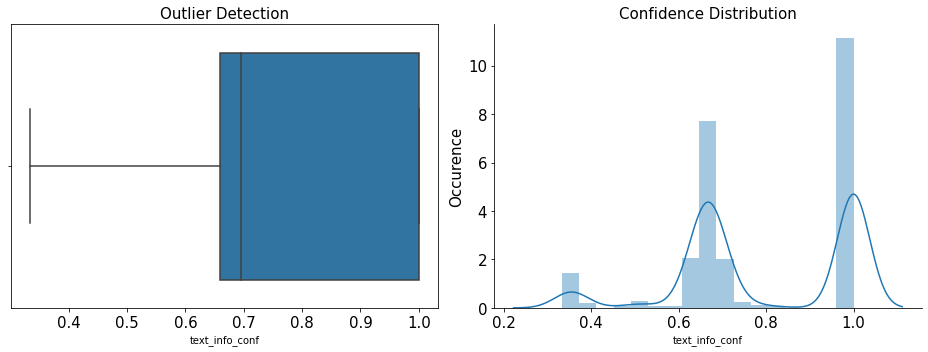

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'text_info_conf', data = dataset, orient = 'v', ax = ax1)
ax1.set_title('Outlier Detection', fontsize=15)
ax1.tick_params(labelsize=15)

sns.distplot(dataset['text_info_conf'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_ylabel('Occurence', fontsize=15)
ax2.set_title('Confidence Distribution', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 


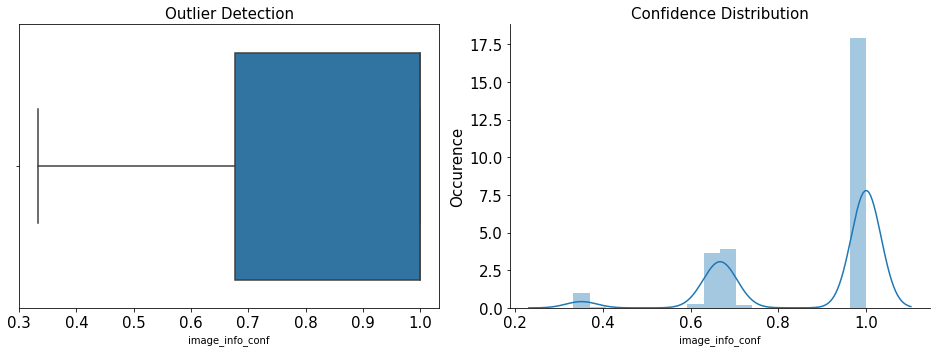

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'image_info_conf', data = dataset, orient = 'v', ax = ax1)
ax1.set_title('Outlier Detection', fontsize=15)
ax1.tick_params(labelsize=15)

sns.distplot(dataset['image_info_conf'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_ylabel('Occurence', fontsize=15)
ax2.set_title('Confidence Distribution', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 


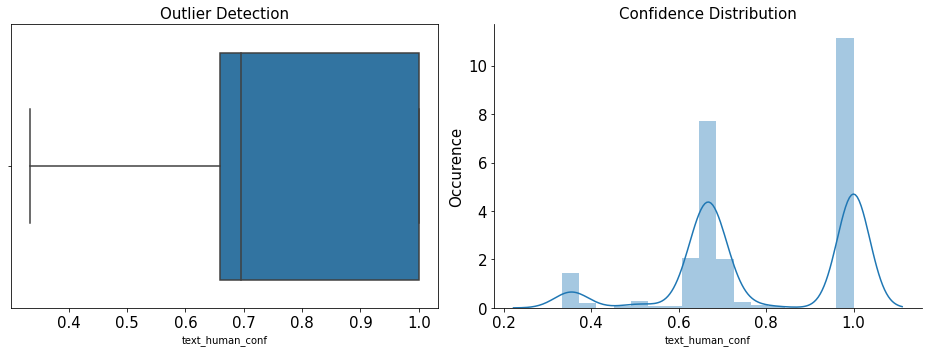

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'text_human_conf', data = dataset, orient = 'v', ax = ax1)
ax1.set_title('Outlier Detection', fontsize=15)
ax1.tick_params(labelsize=15)

sns.distplot(dataset['text_human_conf'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_ylabel('Occurence', fontsize=15)
ax2.set_title('Confidence Distribution', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 


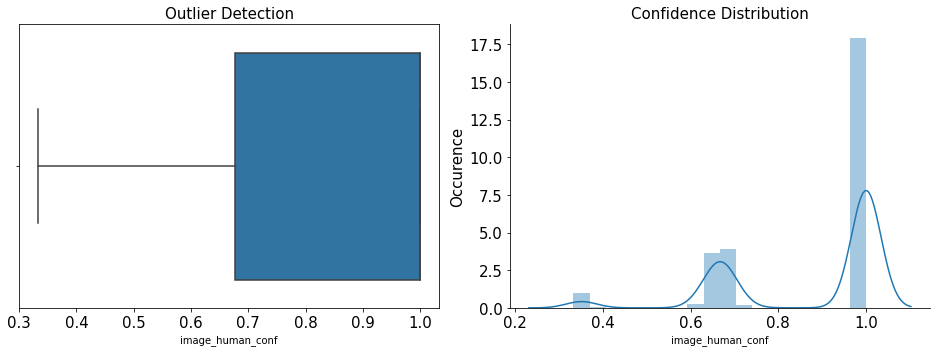

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'image_human_conf', data = dataset, orient = 'v', ax = ax1)
ax1.set_title('Outlier Detection', fontsize=15)
ax1.tick_params(labelsize=15)

sns.distplot(dataset['image_human_conf'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_ylabel('Occurence', fontsize=15)
ax2.set_title('Confidence Distribution', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 


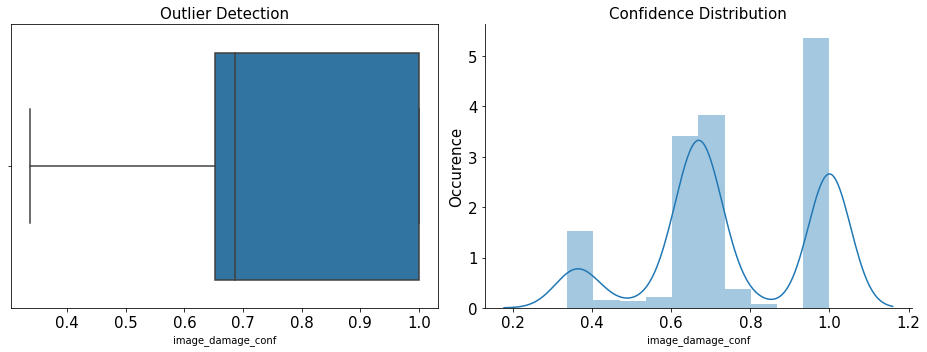

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'image_damage_conf', data = dataset, orient = 'v', ax = ax1)
ax1.set_title('Outlier Detection', fontsize=15)
ax1.tick_params(labelsize=15)

sns.distplot(dataset['image_damage_conf'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_ylabel('Occurence', fontsize=15)
ax2.set_title('Confidence Distribution', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 


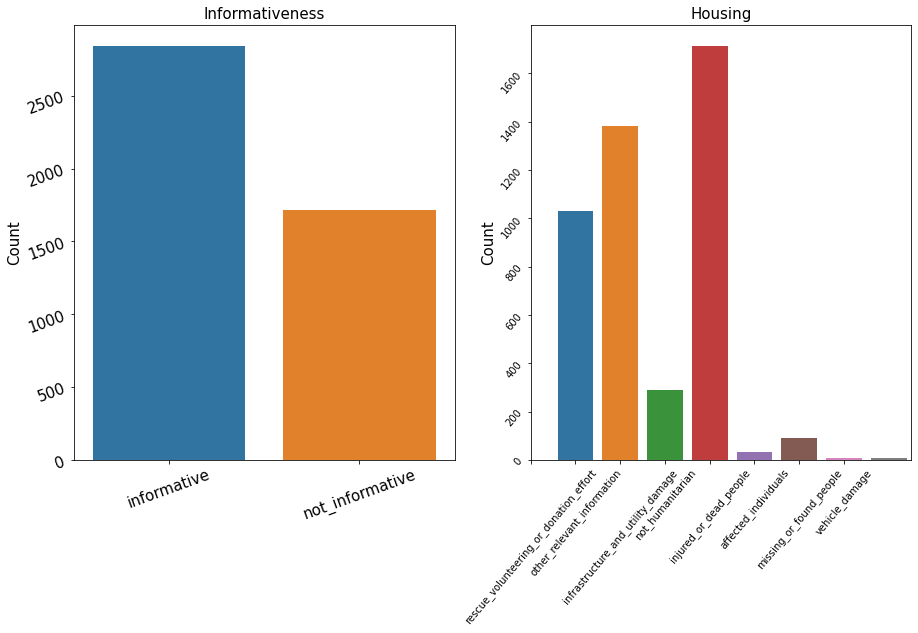

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,8))
sns.countplot(x = 'text_info', data = dataset, ax = ax1)
ax1.set_title('Informativeness', fontsize=15)
ax1.set_xlabel('')
ax1.set_ylabel('Count', fontsize=15)
ax1.set_xticks(range(len(dataset.text_info.unique())))
ax1.tick_params(labelsize=15,rotation=20)


sns.countplot(x = 'text_human', data = dataset, ax = ax2)
ax2.set_title('Housing', fontsize=15)
ax2.set_xlabel('')
ax2.set_ylabel('Count', fontsize=15)
ax2.set_xticks([-1,0,1,2,3,4,5,6])
ax2.set_xticklabels(dataset.text_human.unique())

ax2.tick_params(labelsize=10,rotation=50)

plt.subplots_adjust()

In [21]:
categorical.pop()
for i in categorical:
    print(i,"has following categories with counts as follows")
    print(dataset[i].value_counts(),"\n\n")

text_info has following categories with counts as follows
informative        2843
not_informative    1713
Name: text_info, dtype: int64 


image_info has following categories with counts as follows
not_informative    2325
informative        2231
Name: image_info, dtype: int64 


text_human has following categories with counts as follows
not_humanitarian                          1713
other_relevant_information                1382
rescue_volunteering_or_donation_effort    1031
infrastructure_and_utility_damage          290
affected_individuals                        89
injured_or_dead_people                      34
missing_or_found_people                      9
vehicle_damage                               8
Name: text_human, dtype: int64 


image_human has following categories with counts as follows
not_humanitarian                          2325
infrastructure_and_utility_damage          900
other_relevant_information                 711
rescue_volunteering_or_donation_effort     439
aff

In [22]:
twitter = pd.DataFrame(columns=['tweets'])
twitter['tweets'] = dataset['tweet_text']

In [23]:
twitter.tweets.drop_duplicates(inplace = True)
type(twitter.tweets)

pandas.core.series.Series

In [24]:
stopwords = set(STOPWORDS)
wc = WordCloud(max_font_size=50, max_words=100, background_color="black",stopwords = stopwords).generate(str(twitter['tweets']))

(-0.5, 399.5, 199.5, -0.5)

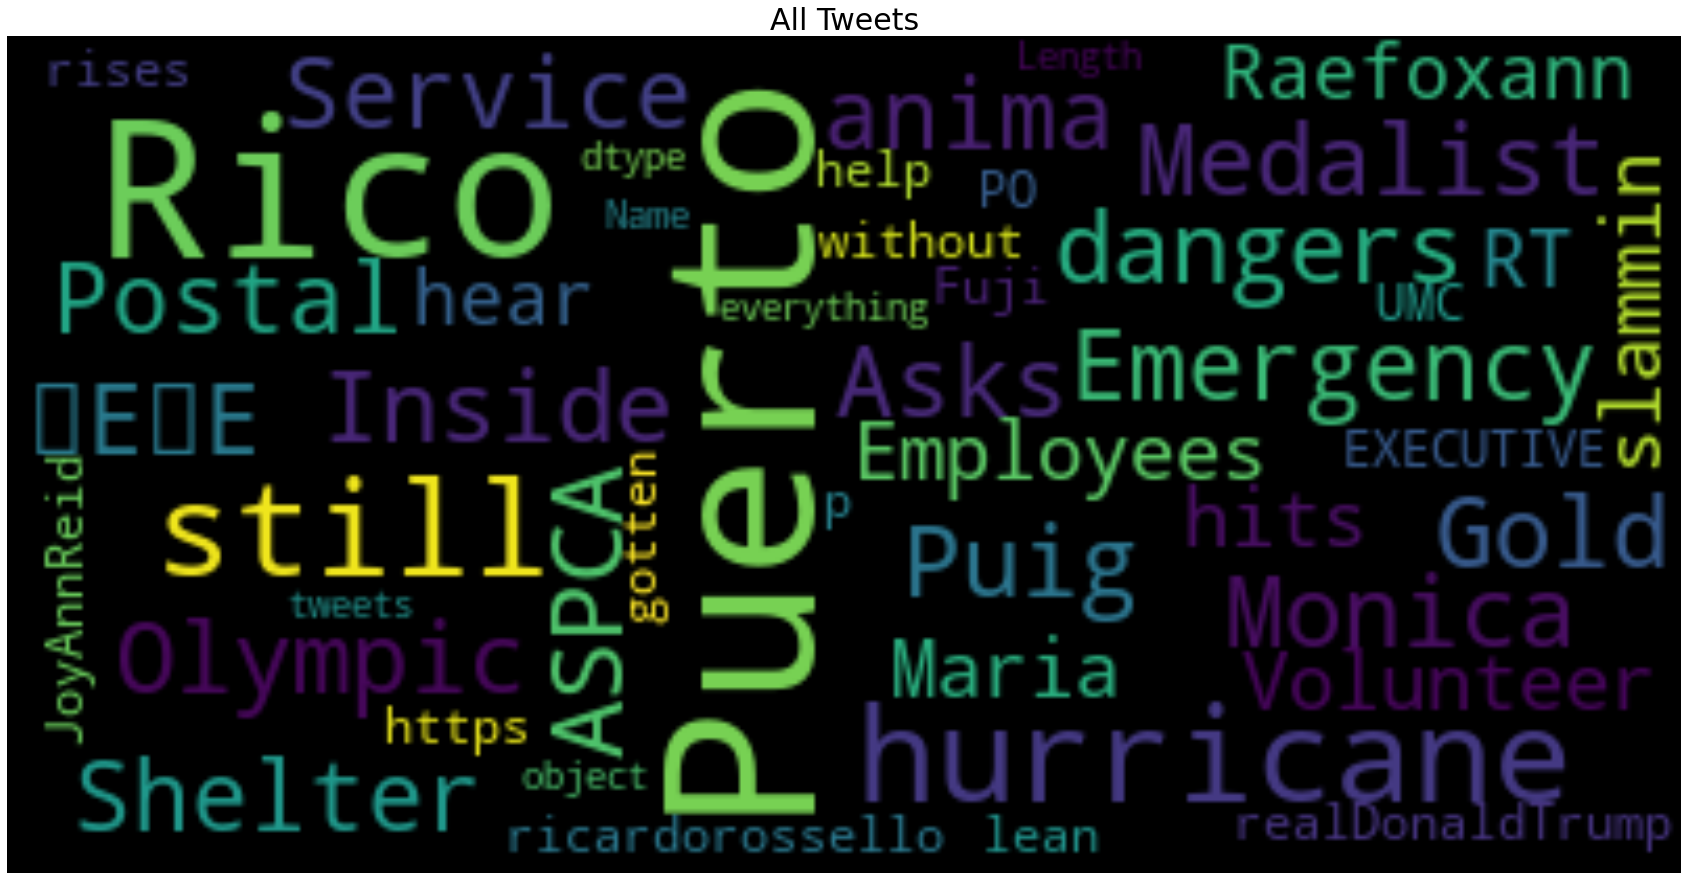

In [25]:
plt.figure(figsize=(30,30))
plt.imshow(wc, interpolation='bilinear')
plt.title('All Tweets', fontsize=30)
plt.axis('off')

In [26]:
#Removing Punctuation
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0–9]+', '', text)
    return text

twitter['clean_text'] = twitter['tweets'].apply(lambda x: remove_punct(x))

#Appliyng tokenization
def tokenization(text):
    text = re.split('\W+', text)
    return text

twitter['clean_text'] = twitter['clean_text'].apply(lambda x: tokenization(x.lower()))

#Removing stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
twitter['clean_text'] = twitter['clean_text'].apply(lambda x: remove_stopwords(x))

#Appliyng Stemmer
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text
twitter['clean_text'] = twitter['clean_text'].apply(lambda x: stemming(x))


In [27]:
twitter

,tweets,clean_text
0,Puerto Rico Olympic Gold Medalist Monica Puig ...,"[puerto, rico, olymp, gold, medalist, monica, ..."
1,"After a hurricane, there are still dangers, so...","[hurrican, still, danger, sometim, insid, refr..."
2,Inside @ASPCA Emergency Shelter for ὃEὃE anima...,"[insid, aspca, emerg, shelter, ὃeὃe, anim, vic..."
3,Postal Service Asks Employees to Volunteer to ...,"[postal, servic, ask, employe, volunt, reloc, ..."
4,Hurricane Maria hits Puerto Rico after slammin...,"[hurrican, maria, hit, puerto, rico, slam, dom..."
...,...,...
4551,RT @Raefoxann: Puerto Rico you are in our hear...,"[rt, raefoxann, puerto, rico, heartsyou, forgo..."
4552,@realDonaldTrump @ricardorossello EXECUTIVE PO...,"[realdonaldtrump, ricardorossello, execut, pow..."
4553,@JoyAnnReid 65% of Puerto Rico still without p...,"[joyannreid, 65, puerto, rico, still, without,..."
4554,Puerto Rico rises with #UMC help ἟5἟7 https://...,"[puerto, rico, rise, umc, help, 5, 7, httpstco..."


(-0.5, 399.5, 199.5, -0.5)

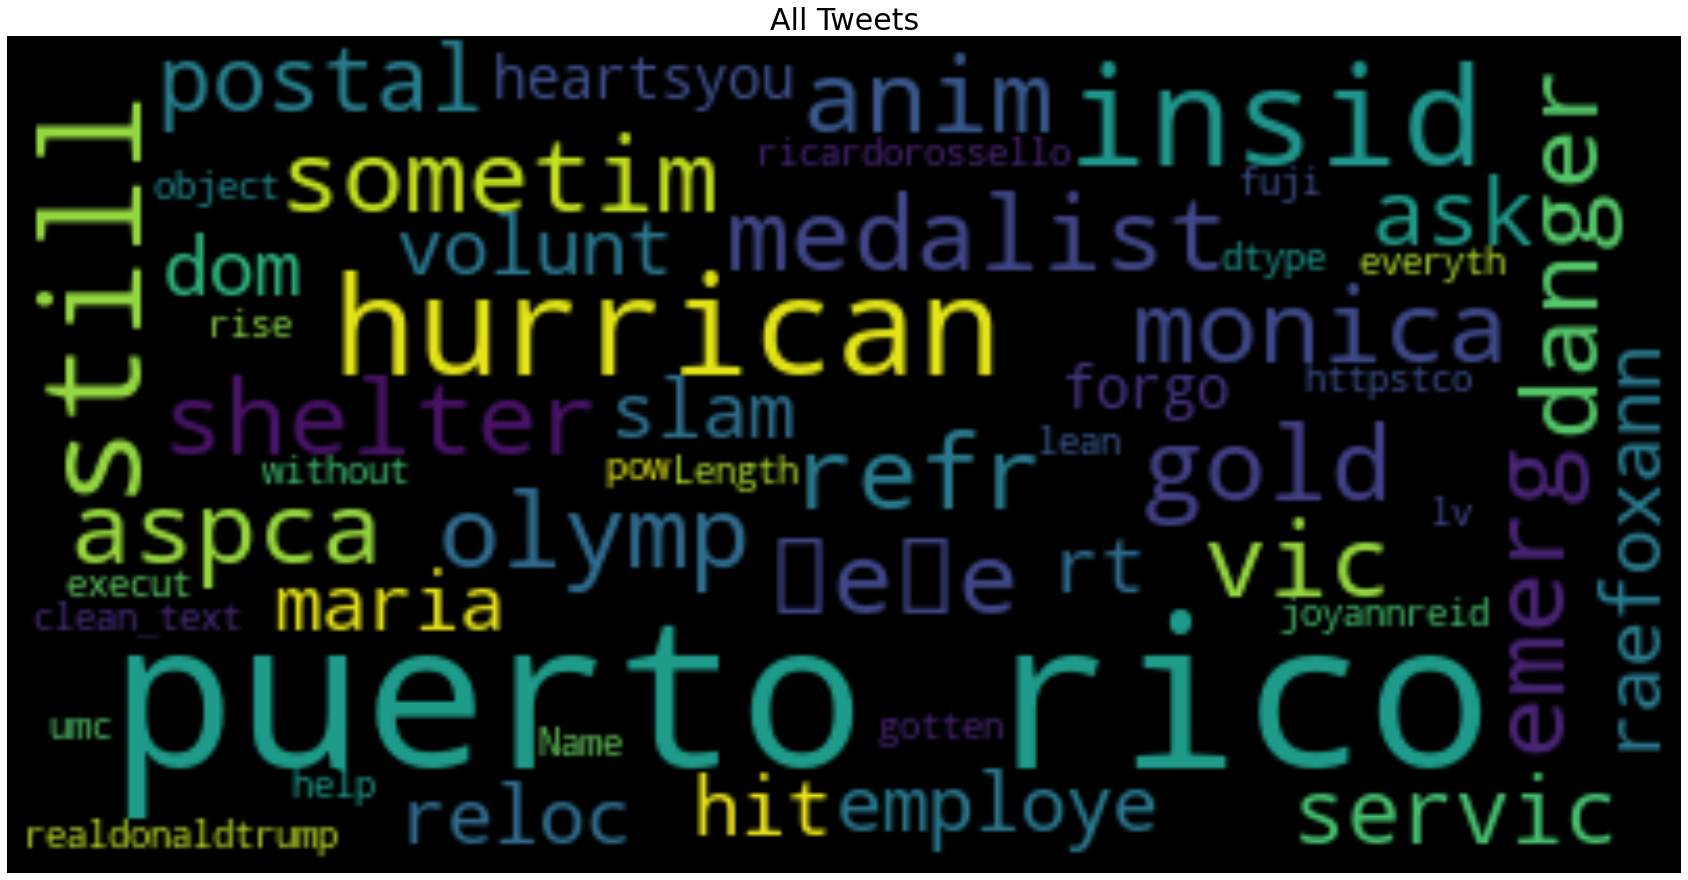

In [28]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="black",stopwords = stopwords).generate(str(twitter['clean_text']))
plt.figure(figsize=(30,30))
plt.imshow(wc, interpolation='bilinear')
plt.title('All Tweets', fontsize=30)
plt.axis('off')

In [29]:
#Appliyng Countvectorizer
countVectorizer = CountVectorizer(analyzer='word') 
countVector = countVectorizer.fit_transform(twitter['tweets'])
print('{} Number of reviews has {} words'.format(countVector.shape[0], countVector.shape[1]))
print(countVectorizer.get_feature_names())
count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())

4556 Number of reviews has 15262 words
['00', '000', '0044', '00dgd1hm76', '00fmeqnvcb', '00m3npn84t', '00o', '00pm', '01', '0155z', '02wtsj9ihb', '031fjmjabc', '0351z', '03s0ckbxu0', '04', '045', '04qf7vyvv6', '04qycvaoex', '04zka7dsfo', '05', '05fhcg5qlv', '05te5pekmz', '05w6vclapb', '06xznks2cm', '07', '0719rbghxq', '07itkcnhpp', '07o9gnbq8f', '07ohsmr8sz', '07oo1whyge', '0822z', '08mlzdjzis', '09', '090s5lfjpn', '0a2dpn471r', '0aqgdkdc0o', '0b1trr4zs7', '0bj75sa8j8', '0chenfybnl', '0ckefxnkvl', '0cqrls1pdh', '0ctt2oxm9r', '0dogwixigo', '0e8vstenul', '0eezmip0sn', '0evmbcripq', '0f5ejb9scs', '0fjgvvnvcx', '0froqomv88', '0g60hmiup6', '0gmwnxweq3', '0grfitgkip', '0hjdf8tfgv', '0hmcg7ivj2', '0https', '0hxeo0yhdx', '0iu1tw3zrr', '0jfqspsxhl', '0jqxfyjlik', '0kkzzktsh7', '0kxoeswa22', '0kzuuay8ct', '0lhsc5j996', '0ljkfr0gzg', '0lnxxzz72r', '0lro535rh9', '0lsdojiavp', '0ltnll27wy', '0ma3z451ps', '0mhdrygyfg', '0mqbzgj58j', '0n1d1we80n', '0n4zuxstgs', '0nlq55r1f3', '0nvyembesz', '0ooylkyut

In [30]:
# Most Used Words
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0,ascending=False).head(20)
countdf[1:20]

,0
https,7054
puerto,2438
rico,2355
maria,1582
hurricane,1482
to,1324
in,1187
the,1104
for,845
of,832


(-0.5, 399.5, 199.5, -0.5)

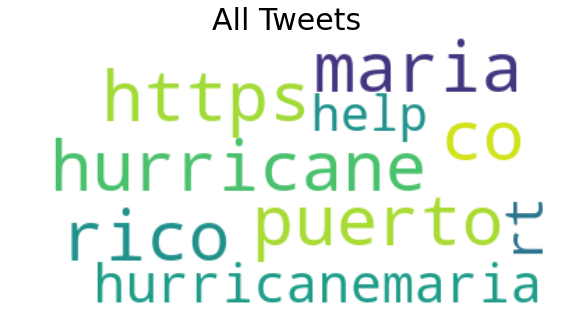

In [31]:
wc = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(str(countdf))
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.title('All Tweets', fontsize=30)
plt.axis('off')